In [28]:
import music21 as m21
from music21 import * 
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from collections import Counter


In [29]:
def shuukei(vocalpart):
    """
    音価・音高のペアのオブジェクトを楽譜から作る
    タイの部分→連結

    """
    record = []
    checker = False
    #タイがついた場合の途中記録用
    pitch_tmp = 0.0
    duration_tmp = 0.0
    for i in vocalpart.flat.notesAndRests.stream():
        
        #タイがついている
        if i.tie:
            #タイのはじめの音ならまず音高を記録する
            if checker == False:
                if i.isNote == True:
                    #record.append([i.pitch.ps,i.duration.quarterLength])
                    #音符はノート番号
                    pitch_tmp = i.pitch.ps
                    duration_tmp += i.duration.quarterLength
                elif i.isRest == True:
                    #record.append(["rest",i.duration.quarterLength])
                    #休符は無限にする
                    pitch_tmp = np.inf
                    duration_tmp += i.duration.quarterLength
                
            #タイの途中の音なら音長を足していく      
            else:
                duration_tmp += i.duration.quarterLength
            
            #タイはついている   
            checker = True
        
        #タイがついてない    
        else:
            checker = False
            #直前がタイの最後の音ならタイでつながって一音になった音を追加
            if not duration_tmp == 0.0:
                record.append([pitch_tmp,duration_tmp])
                duration_tmp = 0.0
            
            #そうでなければ普通に追加
            if i.isNote == True:
                record.append([i.pitch.ps,i.duration.quarterLength])
            elif i.isRest == True:
                record.append([np.inf,i.duration.quarterLength])

    return record

In [71]:
def count_duration(song):
    #[音高,音価]が要素になったリストから音価を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][1])
    duration_count = Counter(lis)
    #集計結果のカウンターを返す
    #sorted_count = sorted(duration_count.items(),key=lambda x:x[0])
    #return sorted_count
    
    return duration_count

In [31]:
def count_pitch(song):
    #[音高,音価]が要素になったリストから音高を集計する
    lis = []
    for n in range(len(song)):
        lis.append(song[n][0])
    pitch_count = Counter(lis)
    #集計結果のカウンターを返す
    return pitch_count

In [32]:
def make_pitch_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音高のBigramのリストを作成する
    pitch_diff = []
    for i in range(len(shuukei_obj)-1):
        pitch_diff.append(shuukei_obj[i+1][0] - shuukei_obj[i][0])
    return pitch_diff

In [33]:
def make_duration_bigram(shuukei_obj):
    #[音高,音価]が要素になったリストから音価のBigramのリストを作成する
    duration_diff = []
    for i in range(len(shuukei_obj)-1):
        duration_diff.append(shuukei_obj[i+1][1] - shuukei_obj[i][1])
    return duration_diff

In [34]:
def jump_rate(bigram_status):
    #バイグラム列から跳躍、下降跳躍、上向跳躍の割合を返す
    up_jump = 0
    down_jump = 0
    slope = 0 
    for key in bigram_status.keys():
        if np.abs(key) <= 2:
            slope += bigram_status[key]
        elif np.abs(key) <= 10000:
            if key > 0:
            	up_jump += bigram_status[key]
            else:
                down_jump += bigram_status[key]
    all_of_notes = up_jump + down_jump + slope
    
    return set((up_jump+down_jump)/all_of_notes,up_jump/all_of_notes,down_jump/all_of_notes)          

In [35]:
def delete_inf(bigram_status): 
    #休符を含むBigramから休符を削除
    del bigram_status[np.inf]
    del bigram_status[-np.inf]
    return bigram_status

In [57]:
def counter_plot(counter,song,section,analysee_name):
    left = counter.keys()
    height = counter.values()
    plt.title("song: {} ({}'s {})".format(song,section,analysee_name))
    plt.bar(left,height)
    plt.grid()
    plt.show()

## 予備実験概要

実験参加者数　6人（21～24歳の男子６人、内音楽経験あり３人）
実施楽曲　6曲＋α


### チェリー

+ 全般的な集計
+ セクション（Aメロ、Bメロ、サビ）ごとの集計
+ アンケートの結果
+ 考察


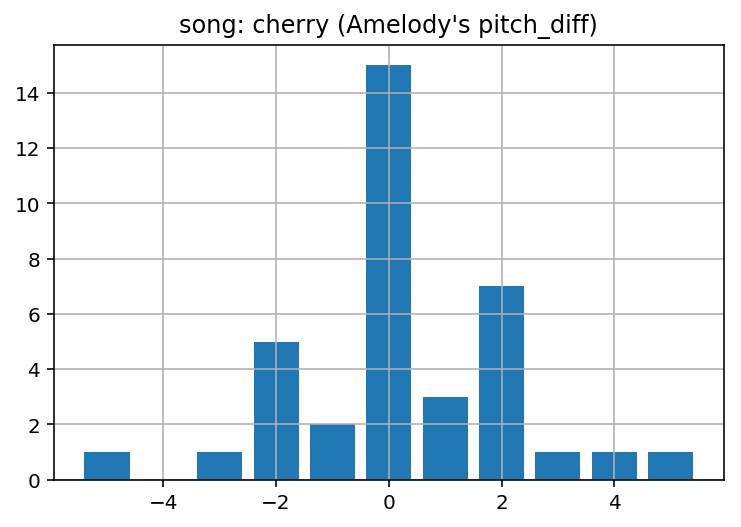

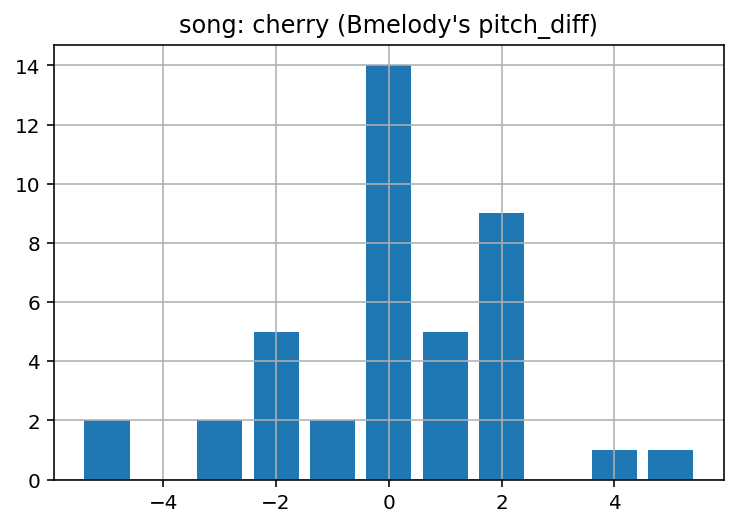

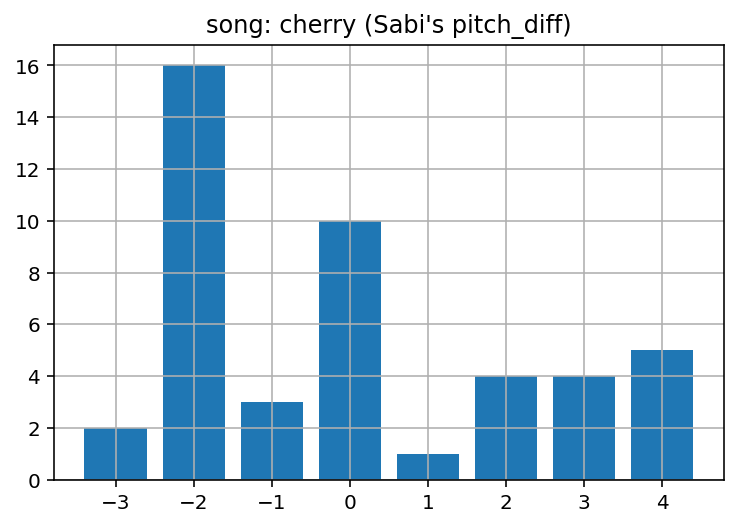

In [58]:
#楽譜の読み込み
cherry = m21.converter.parse("./cherry.xml").parts[0]
#各セクションに分ける
cherry_section = []
cherry_a = cherry.measures(1,8)
cherry_b = cherry.measures(9,16)
cherry_s = cherry.measures(16,24)

cherry_section.append(cherry_a)
cherry_section.append(cherry_b)
cherry_section.append(cherry_s)
#音高,音価の列のオブジェクトを作成
cherry_section_notes = []
for item in cherry_section:
    notes = shuukei(item)
    cherry_section_notes.append(notes)
#音高Bigramを作成
cherry_ontei = []
for item in cherry_section_notes:
    bigram = make_pitch_bigram(item)
    onteiobj = delete_inf(Counter(bigram))
    cherry_ontei.append(onteiobj)
#音高差の集計をプロット
for num,item in enumerate(cherry_ontei):
    counter_plot(item,"cherry",str(analysis_section[num]),"pitch_diff")

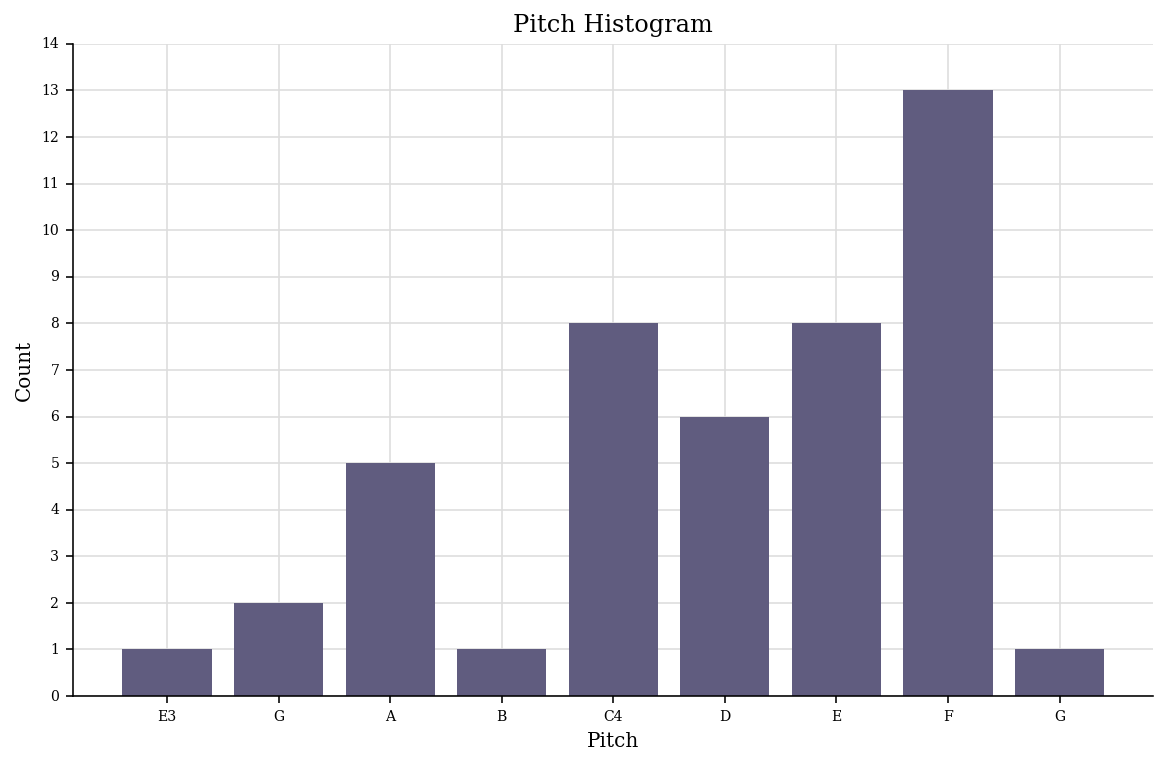

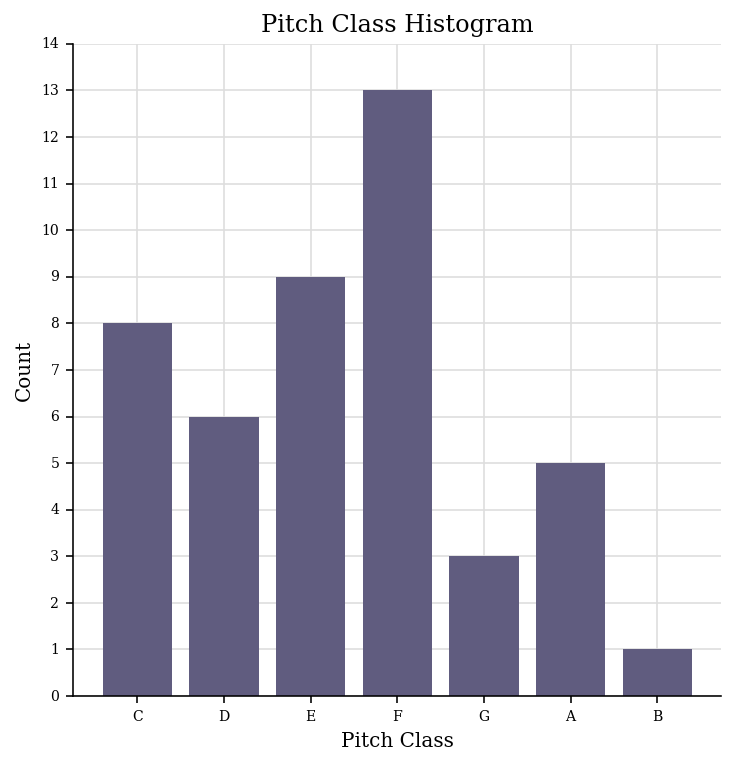

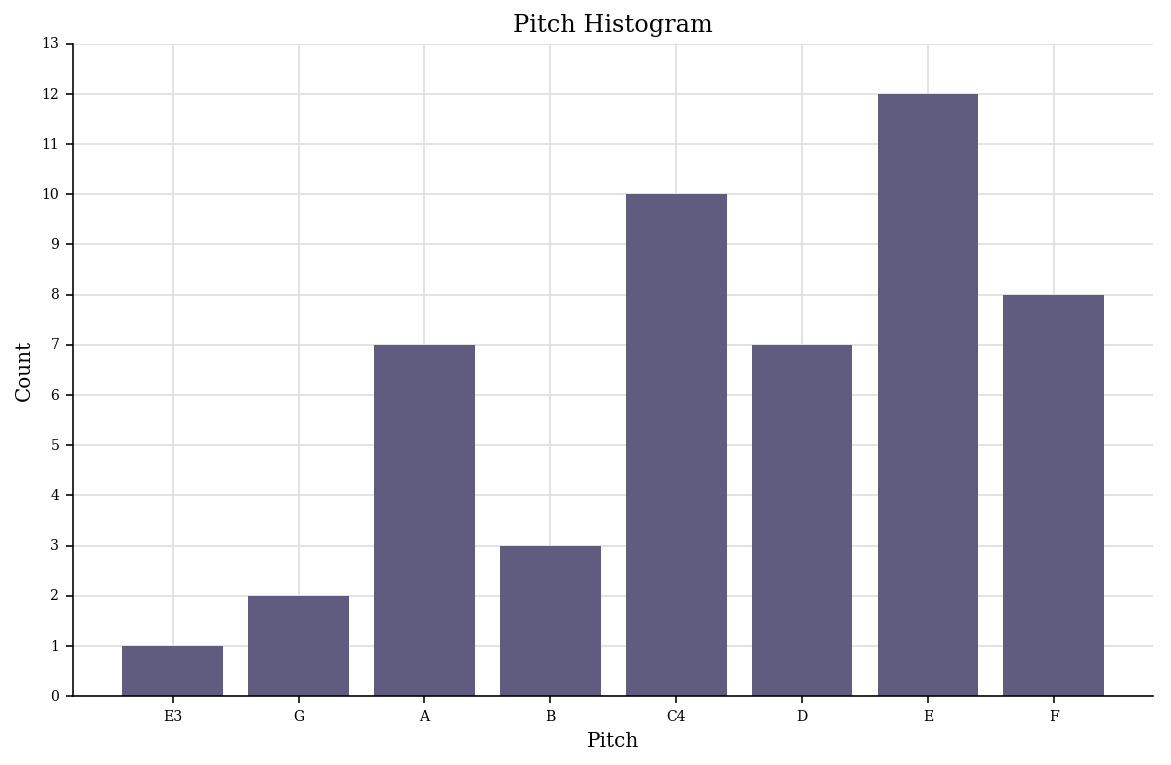

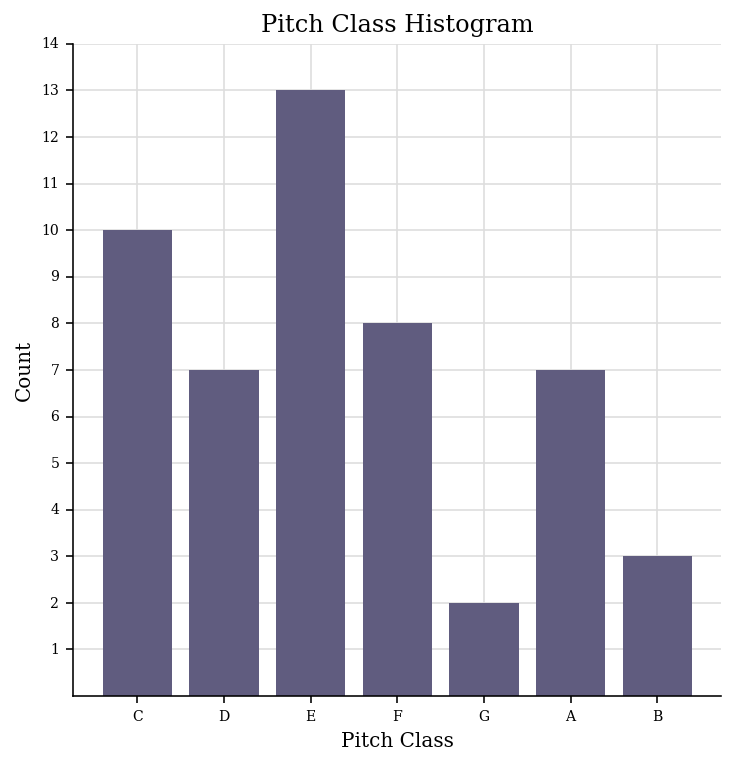

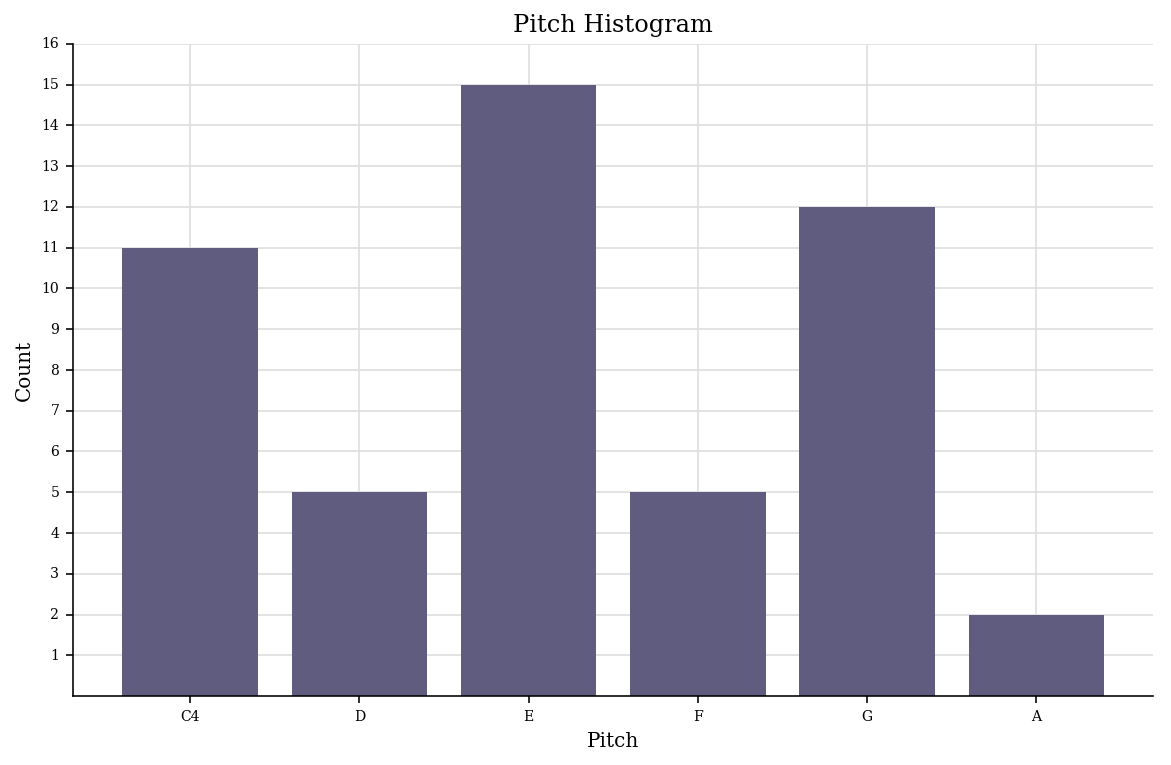

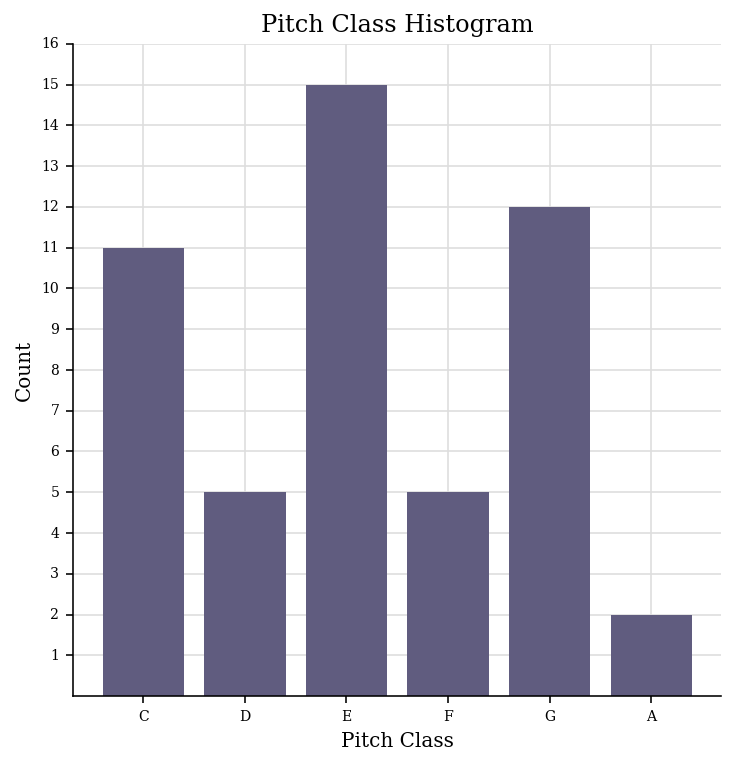

In [73]:
#音高の集計
for item in cherry_section:
    item.plot("histogram","pitch")
    item.plot("histogram","pitchclass")

    

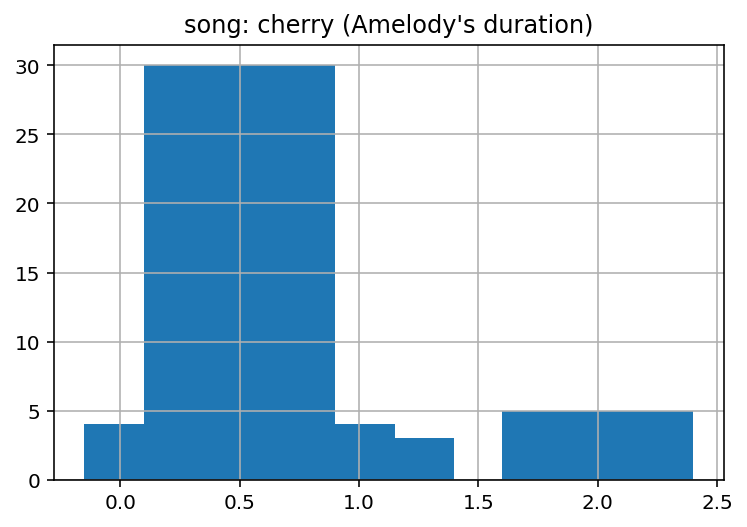

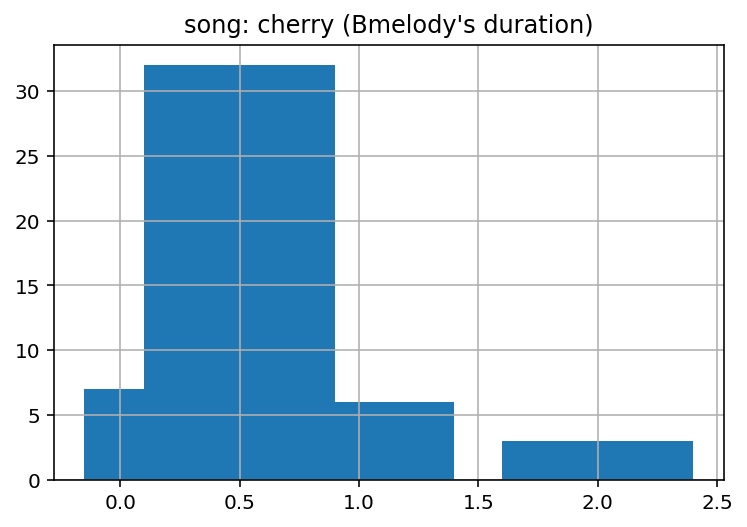

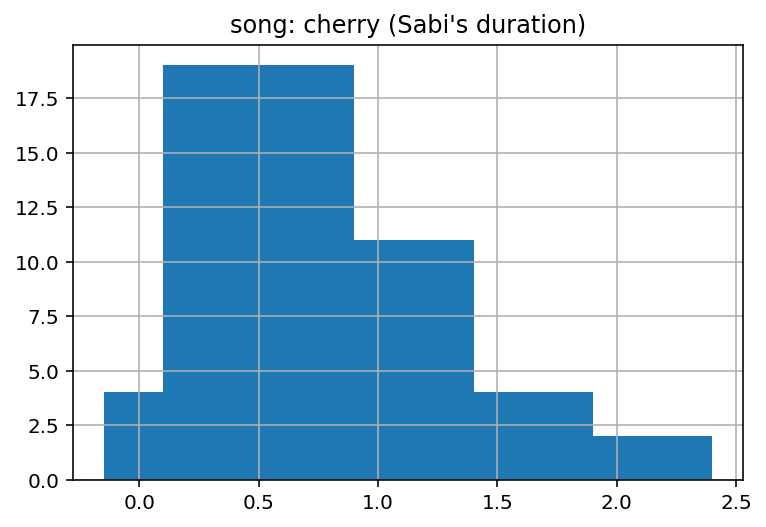

In [74]:
for num,item in enumerate(cherry_section_notes):
    counter_plot(count_duration(item),"cherry",str(analysis_section[num]),"duration")

In [61]:
#調,音符数,跳躍率
analysis_section = {0:"Amelody",1:"Bmelody",2:"Sabi"}
print(len(cherry))
print(analysis.discrete.analyzeStream(cherry,"Krumhansl"))
for num,section in enumerate(cherry_section):
    print(section)
    print("-------{}の統計情報---------".format(analysis_section[num]))
    print("調:{}".format(analysis.discrete.analyzeStream(section,"Krumhansl")))
    

25
C major
<music21.stream.Part トラック 0>
-------Amelodyの統計情報---------
調:d minor
<music21.stream.Part トラック 0>
-------Bmelodyの統計情報---------
調:a minor
<music21.stream.Part トラック 0>
-------Sabiの統計情報---------
調:C major
